In [ ]:
!nvidia-smi

Sun Oct 22 18:56:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |   2923MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [ ]:
# !unzip /content/gdrive/MyDrive/AIT/ISE/computer-vision/lab/week-12/vege_dataset.zip

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F

# Set device to GPU or CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [ ]:
class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    '''
    BottleneckBlock: More powerful residual block with three convs, used for Resnet50 and up
    '''
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        # If the output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super().__init__()
#         self.in_planes = 64
#         # Initial convolution
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         # Residual blocks
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         # FC layer = 1 layer
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.EXPANSION
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_prob=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)  # Add dropout layer with specified dropout probability

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)  # Apply dropout before the linear layer
        out = self.linear(out)
        return out

In [ ]:
def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of two convolutions each: 3*2 + 4*2 + 6*2 + 3*2 = 32
    last FC layer: 1
    Total layers: 1+32+1 = 34
    '''
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of three convolutions each: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1
    Total layers: 1+48+1 = 50
    '''
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 23, 3] sets of three convolutions each: 3*3 + 4*3 + 23*3 + 3*3 = 99
    last FC layer: 1
    Total layers: 1+99+1 = 101
    '''
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 8, 36, 3] sets of three convolutions each: 3*3 + 8*3 + 36*3 + 3*3 = 150
    last FC layer: 1
    Total layers: 1+150+1 = 152
    '''
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

In [ ]:
# import important library
from torch.utils.data import Dataset, DataLoader


class BasilDataset(Dataset):
    def __init__(self, root_path="/vege_dataset/", transform=None):
        return

    def __len__(self):
        return 0

    def __getitem__(self, i):
        return

In [ ]:
from torch.utils.data import Dataset, DataLoader
from os import listdir
from PIL import Image


# class BasilDataset(Dataset):
#     def __init__(self, root_path="vege_dataset/", transform=None):
#         # keep root directory
#         self.dir = root_path
#         # keep transform
#         self.transform = transform

#         # read all files in kapao and horapa folder
#         list_kaprao = listdir(root_path + 'kapao/')
#         list_horapa = listdir(root_path + 'horapa/')
#         # calculate all number for each class (just in case)
#         self.kaprao_len = len(list_kaprao)
#         self.horapa_len = len(list_horapa)

#         # put the data file path into ids
#         self.ids = [self.dir + 'kapao/' + file for file in list_kaprao if not file.startswith('.')]
#         self.ids.extend([self.dir + 'horapa/' + file for file in list_horapa if not file.startswith('.')])

#     def __len__(self):
#         return self.kaprao_len + self.horapa_len

#     def __getitem__(self, i):
#         idx = self.ids[i]
#         img_file = idx

#         # open photo
#         pil_img = Image.open(img_file)

#         # resize, normalize and convert to pytorch tensor
#         if self.transform:
#             img = self.transform(pil_img)
#         self.pil_img = pil_img

#         # get label from file list counter
#         if i < self.kaprao_len:
#             label = 0
#         else:
#             label = 1

#         return {
#             'image': img,
#             'label': label,
#             'file_name' : img_file,
#         }

from os import listdir
from PIL import Image
from torch.utils.data import Dataset

class BasilDataset(Dataset):
    def __init__(self, root_path="vege_dataset/", transform=None):
        self.dir = root_path
        self.transform = transform

        list_kaprao = [file for file in listdir(root_path + 'kapao/') if not file.startswith('.')]
        list_horapa = [file for file in listdir(root_path + 'horapa/') if not file.startswith('.')]

        self.kaprao_len = len(list_kaprao)
        self.horapa_len = len(list_horapa)

        self.ids = [self.dir + 'kapao/' + file for file in list_kaprao]
        self.ids.extend([self.dir + 'horapa/' + file for file in list_horapa])

    def __len__(self):
        return self.kaprao_len + self.horapa_len

    def __getitem__(self, i):
        if i >= len(self.ids):
            raise IndexError("list index out of range")

        idx = self.ids[i]
        img_file = idx

        pil_img = Image.open(img_file)

        if self.transform:
            img = self.transform(pil_img)
        self.pil_img = pil_img

        if i < self.kaprao_len:
            label = 0
        else:
            label = 1

        return {
            'image': img,
            'label': label,
            'file_name': img_file,
        }



In [ ]:
root = "vege_dataset/"

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(28), # CenterCrop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = BasilDataset(root, transform)

kaprao
vege_dataset/kapao/20220425_205015_resize.jpg


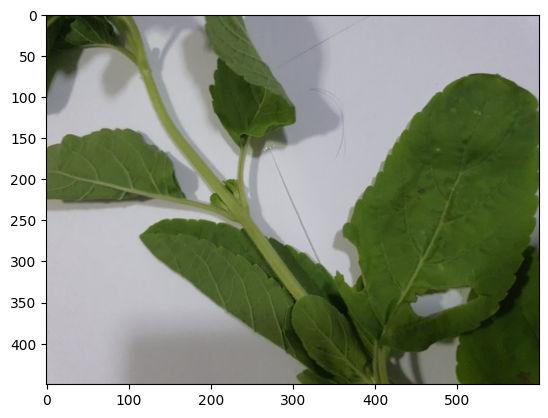

In [ ]:
import matplotlib.pyplot as plt

output_label = ['kaprao', 'horapa']

batch = dataset[0]
image, label, filename = batch['image'], batch['label'], batch['file_name']
pil_img = Image.open(filename)

print(output_label[label])
print(filename)
# (3, 224, 224) pytorch
# pyplot -> (224,224,3)
plt.imshow(pil_img)
plt.show()

In [ ]:
# train_loader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True)
# Split the dataset into train and test sets
dataset_length = len(dataset)
train_size = int(0.9 * dataset_length)
test_size = dataset_length - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=32)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = ResNet101(2).to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [ ]:
model_name = "resnet101_vege"

# Training loop
num_epochs = 50
train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:  # Change here
        images, labels = batch['image'], batch['label']  # Change here
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:  # Change here
            images, labels = batch['image'], batch['label']  # Change here
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = running_loss / len(test_loader)
    valid_accuracy = correct / total

    # Store loss and accuracy values
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_accuracy_list.append(train_accuracy)
    valid_accuracy_list.append(valid_accuracy)

    # Print the training/validation statistics
    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_accuracy:.4f}")

    # Update the learning rate
    # scheduler.step()
    scheduler1.step()
    scheduler2.step()

# Save the trained model
torch.save(model.state_dict(), model_name+".pth")


Epoch: 1/50 | Train Loss: 0.8811 | Train Acc: 0.5582 | Valid Loss: 2.4973 | Valid Acc: 0.3714
Epoch: 2/50 | Train Loss: 0.8534 | Train Acc: 0.6435 | Valid Loss: 1.0124 | Valid Acc: 0.6357
Epoch: 3/50 | Train Loss: 0.8646 | Train Acc: 0.6938 | Valid Loss: 0.4970 | Valid Acc: 0.7857
Epoch: 4/50 | Train Loss: 0.5772 | Train Acc: 0.7592 | Valid Loss: 0.4367 | Valid Acc: 0.8214
Epoch: 5/50 | Train Loss: 0.5143 | Train Acc: 0.8062 | Valid Loss: 0.3555 | Valid Acc: 0.7929
Epoch: 6/50 | Train Loss: 0.4730 | Train Acc: 0.8198 | Valid Loss: 0.3634 | Valid Acc: 0.8500
Epoch: 7/50 | Train Loss: 0.3911 | Train Acc: 0.8493 | Valid Loss: 0.2885 | Valid Acc: 0.8714
Epoch: 8/50 | Train Loss: 0.4735 | Train Acc: 0.8477 | Valid Loss: 0.3561 | Valid Acc: 0.8500
Epoch: 9/50 | Train Loss: 0.4297 | Train Acc: 0.8501 | Valid Loss: 0.3384 | Valid Acc: 0.8286
Epoch: 10/50 | Train Loss: 0.3364 | Train Acc: 0.8868 | Valid Loss: 0.2930 | Valid Acc: 0.8643
Epoch: 11/50 | Train Loss: 0.3232 | Train Acc: 0.8892 | Val

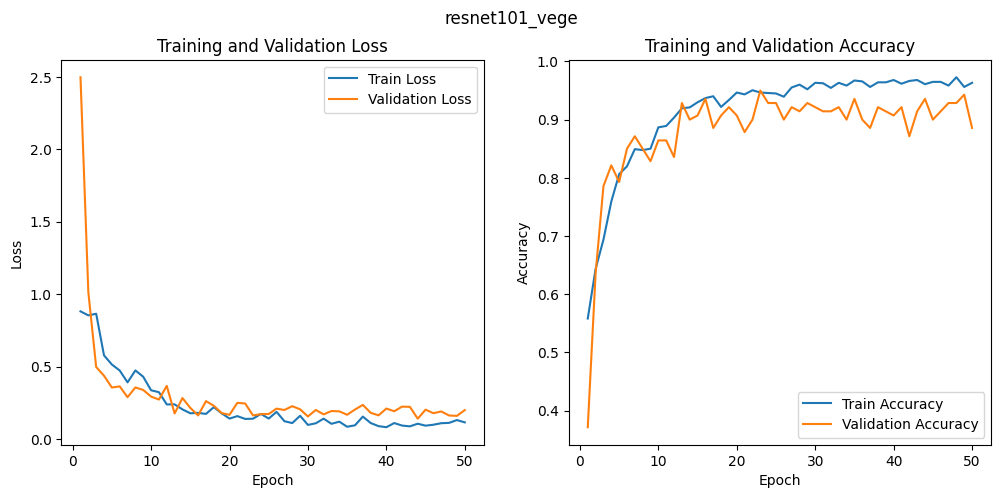

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Plot training and validation loss
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Plot training and validation accuracy
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), valid_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.suptitle(model_name)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


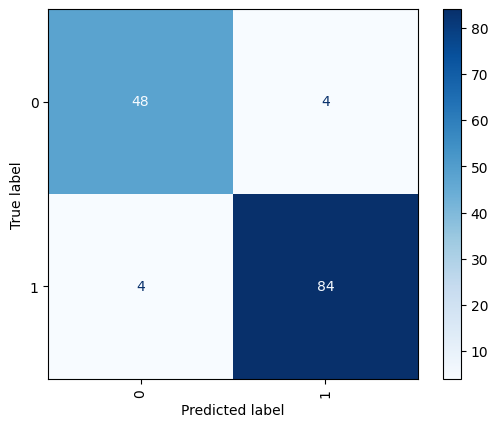

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

loaded_model = ResNet101(2)
loaded_model.load_state_dict(torch.load('/content/resnet101_vege.pth'))
loaded_model.to(device)  # Move the loaded model to the same device as the data

# Test the loaded model
def test_loaded_model(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch['image'], batch['label']
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Test the loaded model
all_preds, all_labels = test_loaded_model(loaded_model, test_loader, device)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix using ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))

# Plot the confusion matrix
cmd.plot(cmap='Blues', xticks_rotation='vertical')

# Show the plot
plt.show()
